# Project MCFS: Credit Default Prediction for Chinese Credit Bonds

## Monash Center for Financial Studies (MCFS)
#### Research Assistant: Priscila Grecov

### Table of Contents:

* [Introduction](#sec_intr)
* [0. Libraries](#sec_0)
* [1. Loading Train and Test datasets](#sec_1)
* [1.1. Creating dummies for the categorical variables](#sec_1_1)
* [1.2. Builduing the train and test datasets](#sec_1_2)
* [2. Five Models: Preliminary Estimations](#sec_2)
* [3. Five Models: Gridsearch Hyper-Parameters](#sec_3)
* [4. Predicted Probabilities (after hyper-parameter tuning process)](#sec_4)
* [4.1. Recovering the optimal parameters and estimator from grid-search process to re-set the models for training](#sec_4_1)
* [4.2. New Predicted Probabilities after Grid-search process](#sec_4_2)
* [5. Results: Comparative Probability Distributions](#sec_5)
* [6. Fitting Optimal Models on Training Data](#sec_6)
* [7. Results: Comparative Test Scoring](#sec_7)
* [7.1. Confusion Matrices](#sec_7_1)
* [7.2. Conclusion about classifiers](#sec_7_2)
* [7.3. considering other models](#sec_7_3)
* [8. Conclusion](#sec_8)


## INTRODUCTION

This script aims to find a classifier model that perform better than models built by previous in the task of predicting the default for Chinese credit bonds using some accounting financial ratios.

This work is in progress.

## 0. Libraries <a class="anchor" id="sec_0"></a>

In [2]:
import csv
import numpy as np
import pandas as pd

In [3]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

## 1. Loading Train and Test datasets <a class="anchor" id="sec_1"></a>

In [5]:
# reading the train data
train = pd.read_csv('dftrain_total_adjusted_v2_cleanOut.csv',  sep=",", encoding='cp1252')

# cleaning from missing data
train = train.dropna()

In [6]:
# checking the number of industry sectors in our dataset
len(train.Industry_Sector.unique())

11

In [7]:
# printing the names of industry sectors in our dataset
train.Industry_Sector.unique()

array(['Financials', 'Industrials', 'Materials', 'public utility',
       'Optional consumption',
       'Real estate development (unanimous rating)', 'Consumer Staples',
       'energy', 'information technology', 'Health Care',
       'telecommunications service'], dtype=object)

In [9]:
# checking the format of dataset
train.head()

,Unnamed: 0,X,Issuer,Year,Quarter,Industry_Sector,Industry_Type,Y,x1,x2,x3,x4,key,Y2,Type,Key2,TA_1
35,36,36,Abc International,2018,Q4,Financials,Diversified Financials,0,0.100782,0.109006,0.073365,0.471992,Abc International-2018,0,CB,Abc International-2018-Q4-CB,21.765297
37,38,38,Abc International,2019,Q4,Financials,Diversified Financials,0,0.250877,0.142887,0.084619,0.514708,Abc International-2019,0,CB,Abc International-2019-Q4-CB,21.837399
38,39,39,Abc International,2020,Q2,Financials,Diversified Financials,0,0.338522,0.139600,0.085933,0.440439,Abc International-2020,0,CB,Abc International-2020-Q2-CB,22.007202
39,40,40,Abc International,2020,Q4,Financials,Diversified Financials,0,0.170020,0.191982,0.084987,0.659811,Abc International-2020,0,CB,Abc International-2020-Q4-CB,21.794553
48,49,49,"Addsino Co.,Ltd.",2017,Q2,Industrials,Capital Goods,0,0.375760,0.112455,0.049536,3.198252,"Addsino Co.,Ltd.-2017",0,CB,"Addsino Co.,Ltd.-2017-Q2-CB",22.699104


In [10]:
# checking the size of issuers
len(train.Issuer.unique())

5223

### 1.1. Creating dummies for the categorical variables <a class="anchor" id="sec_1_1"></a>

In [11]:
# Creating dummy variables for each one of the Industry Sectors
train = pd.get_dummies(train, columns=['Industry_Sector'], drop_first=False)

In [12]:
# Creating a dummy variable for Type Bond variable
train['Type_dummy'] = train.Type.apply(lambda x: 1 if x=='EB' else 0)

In [13]:
# printing the summary statistics for our train dataset
train.describe()

,Unnamed: 0,X,Year,Y,x1,x2,x3,x4,Y2,TA_1,...,Industry_Sector_Health Care,Industry_Sector_Industrials,Industry_Sector_Materials,Industry_Sector_Optional consumption,Industry_Sector_Real estate development (unanimous rating),Industry_Sector_energy,Industry_Sector_information technology,Industry_Sector_public utility,Industry_Sector_telecommunications service,Type_dummy
count,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,...,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000
mean,29655.645391,29689.890869,2018.453482,0.017680,0.331445,0.072541,0.023530,1.069390,0.008672,23.953963,...,0.012828,0.654760,0.060319,0.049989,0.062408,0.022004,0.024286,0.048500,0.000865,0.379327
std,16969.998938,16987.046682,1.093311,0.131787,0.326394,0.258230,0.069559,3.831383,0.092719,1.287148,...,0.112532,0.475452,0.238079,0.217925,0.241899,0.146698,0.153937,0.214823,0.029395,0.485225
min,36.000000,36.000000,2017.000000,0.000000,-11.361490,-20.429720,-4.382412,-0.938441,0.000000,6.433310,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14970.000000,14986.000000,2017.000000,0.000000,0.084953,0.031468,0.009612,0.490678,0.000000,23.195370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29849.000000,29885.000000,2018.000000,0.000000,0.321758,0.061083,0.018081,0.724084,0.000000,23.857280,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,44510.000000,44562.000000,2019.000000,0.000000,0.595779,0.106174,0.035425,1.136117,0.000000,24.634960,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,58353.000000,58408.000000,2020.000000,1.000000,0.998645,0.993871,1.600706,441.385825,1.000000,30.100570,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 1.2. Builduing the train and test datasets <a class="anchor" id="sec_1_2"></a>
#### a) Train Data

In [14]:
# dividing our train data into labels data (Y) and predictors data (X)
y_train = pd.DataFrame(train, columns=['Y2']) # label train data

# selecting the variables to be used as predictors in our train data
X_train = pd.DataFrame(train, columns=['x1','x2','x3','x4','Industry_Sector_Consumer Staples','Industry_Sector_Financials',
                                       'Industry_Sector_Health Care',
                                       'Industry_Sector_Industrials','Industry_Sector_Materials',
                                       'Industry_Sector_Optional consumption',
                                       'Industry_Sector_Real estate development (unanimous rating)','Industry_Sector_energy',
                                       'Industry_Sector_information technology','Industry_Sector_public utility',
                                       'Industry_Sector_telecommunications service','Type_dummy'])

#### Checking the proper builduing of predictor and label datasets.

In [15]:
X_train.head()

,x1,x2,x3,x4,Industry_Sector_Consumer Staples,Industry_Sector_Financials,Industry_Sector_Health Care,Industry_Sector_Industrials,Industry_Sector_Materials,Industry_Sector_Optional consumption,Industry_Sector_Real estate development (unanimous rating),Industry_Sector_energy,Industry_Sector_information technology,Industry_Sector_public utility,Industry_Sector_telecommunications service,Type_dummy
35,0.100782,0.109006,0.073365,0.471992,0,1,0,0,0,0,0,0,0,0,0,0
37,0.250877,0.142887,0.084619,0.514708,0,1,0,0,0,0,0,0,0,0,0,0
38,0.338522,0.139600,0.085933,0.440439,0,1,0,0,0,0,0,0,0,0,0,0
39,0.170020,0.191982,0.084987,0.659811,0,1,0,0,0,0,0,0,0,0,0,0
48,0.375760,0.112455,0.049536,3.198252,0,0,0,1,0,0,0,0,0,0,0,0


In [17]:
y_train.head()

,Y2
35,0
37,0
38,0
39,0
48,0


In [18]:
# checking the absence of null values (1st way)
y_train.isnull().values.any()

False

In [19]:
# checking the absence of null values (2nd way)
y_train.isnull().sum().sum()

0

In [20]:
y = train.pop('Y2')
len(y.unique())

2

#### b) Test Data

In [22]:
# loading test data and cleaning it from missings
test = pd.read_csv('dftest_total_toPredict_withLabel.csv')
test = test.dropna()
test.head()

,Unnamed: 0,X1,X2,X3,X4,Type,Issuer - Wind Sector,Y
0,1,0.606898,0.087141,0.060246,0.560680,CB,Industrials,0
1,2,0.574106,0.084837,0.057377,0.542234,CB,Industrials,0
2,3,0.543272,0.085818,0.057159,0.550631,CB,Industrials,0
3,4,0.175495,0.173244,0.037397,0.265165,CB,Real estate development (unanimous rating),0
4,5,0.618362,0.046765,0.016865,0.451355,CB,Industrials,0


In [23]:
# renaming the column names from test data according the columns names of train data
test = test.rename(columns={"Issuer - Wind Sector": "Industry_Sector",
                           "X1": "x1","X2": "x2","X3": "x3","X4": "x4"})

In [24]:
# checking the number of different Industry Sectors in test dataset
len(test.Industry_Sector.unique())

12

In [25]:
# listing the names of industry sectors in the test dataset
test.Industry_Sector.unique()

array(['Industrials', 'Real estate development (unanimous rating)',
       'energy', 'Optional consumption', 'Financials', 'Materials',
       'Health Care', 'information technology', 'public utility',
       'Consumer Staples', 'telecommunications service', 'Capital Goods'],
      dtype=object)

In [26]:
# Creating dummy variables for each one of the Industry Sectors
test = pd.get_dummies(test, columns=['Industry_Sector'], drop_first=False)

In [27]:
# Creating a dummy variable for Type Bond variable
test['Type_dummy'] = test.Type.apply(lambda x: 1 if x=='EB' else 0)

In [28]:
# printing the summary statistics for our train dataset
test.describe()

,Unnamed: 0,x1,x2,x3,x4,Y,Industry_Sector_Capital Goods,Industry_Sector_Consumer Staples,Industry_Sector_Financials,Industry_Sector_Health Care,Industry_Sector_Industrials,Industry_Sector_Materials,Industry_Sector_Optional consumption,Industry_Sector_Real estate development (unanimous rating),Industry_Sector_energy,Industry_Sector_information technology,Industry_Sector_public utility,Industry_Sector_telecommunications service,Type_dummy
count,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000
mean,3745.152952,0.280909,0.072674,0.021908,0.700157,0.024862,0.000405,0.008512,0.052155,0.010269,0.624510,0.059316,0.040670,0.105661,0.031347,0.014593,0.052155,0.000405,0.326577
std,2172.982293,0.289558,0.102178,0.047230,0.564132,0.155713,0.020131,0.091875,0.222355,0.100821,0.484282,0.236232,0.197538,0.307425,0.174266,0.119923,0.222355,0.020131,0.468993
min,1.000000,-0.778094,-1.494044,-1.271962,-0.317545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1865.000000,0.053444,0.031553,0.008864,0.428759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3735.000000,0.277227,0.058283,0.017229,0.571458,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5626.000000,0.511991,0.101412,0.033968,0.824109,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,7517.000000,0.956008,0.684474,0.710435,12.078470,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
# dividing our test data into labels data (Y) and predictors data (X)
y_test = pd.DataFrame(test, columns=['Y'])

# selecting the variables to be used as predictors in our train data
X_test = pd.DataFrame(test, columns=['x1','x2','x3','x4','Industry_Sector_Consumer Staples','Industry_Sector_Financials',
                                       'Industry_Sector_Health Care',
                                       'Industry_Sector_Industrials','Industry_Sector_Materials',
                                       'Industry_Sector_Optional consumption',
                                       'Industry_Sector_Real estate development (unanimous rating)','Industry_Sector_energy',
                                       'Industry_Sector_information technology','Industry_Sector_public utility',
                                       'Industry_Sector_telecommunications service','Type_dummy'])


#### Checking the proper builduing of predictor and label datasets for test data.

In [31]:
X_test.head()

,x1,x2,x3,x4,Industry_Sector_Consumer Staples,Industry_Sector_Financials,Industry_Sector_Health Care,Industry_Sector_Industrials,Industry_Sector_Materials,Industry_Sector_Optional consumption,Industry_Sector_Real estate development (unanimous rating),Industry_Sector_energy,Industry_Sector_information technology,Industry_Sector_public utility,Industry_Sector_telecommunications service,Type_dummy
0,0.606898,0.087141,0.060246,0.560680,0,0,0,1,0,0,0,0,0,0,0,0
1,0.574106,0.084837,0.057377,0.542234,0,0,0,1,0,0,0,0,0,0,0,0
2,0.543272,0.085818,0.057159,0.550631,0,0,0,1,0,0,0,0,0,0,0,0
3,0.175495,0.173244,0.037397,0.265165,0,0,0,0,0,0,1,0,0,0,0,0
4,0.618362,0.046765,0.016865,0.451355,0,0,0,1,0,0,0,0,0,0,0,0


In [30]:
y_test.head()

,Y
0,0
1,0
2,0
3,0
4,0


In [34]:
# checking the absence of null values (1st way)
X_test.isnull().values.any()

False

In [35]:
# checking the absence of null values (2ndt way)
X_test.isnull().sum().sum()

0

#### Summary statistics for final X_train and X_test datasets.

In [32]:
# summary statistics train data
X_train.describe()

,x1,x2,x3,x4,Industry_Sector_Consumer Staples,Industry_Sector_Financials,Industry_Sector_Health Care,Industry_Sector_Industrials,Industry_Sector_Materials,Industry_Sector_Optional consumption,Industry_Sector_Real estate development (unanimous rating),Industry_Sector_energy,Industry_Sector_information technology,Industry_Sector_public utility,Industry_Sector_telecommunications service,Type_dummy
count,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.00000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000,41629.000000
mean,0.331445,0.072541,0.023530,1.069390,0.015662,0.04838,0.012828,0.654760,0.060319,0.049989,0.062408,0.022004,0.024286,0.048500,0.000865,0.379327
std,0.326394,0.258230,0.069559,3.831383,0.124166,0.21457,0.112532,0.475452,0.238079,0.217925,0.241899,0.146698,0.153937,0.214823,0.029395,0.485225
min,-11.361490,-20.429720,-4.382412,-0.938441,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.084953,0.031468,0.009612,0.490678,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.321758,0.061083,0.018081,0.724084,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.595779,0.106174,0.035425,1.136117,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.998645,0.993871,1.600706,441.385825,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
# summary statistics test data
X_test.describe()

,x1,x2,x3,x4,Industry_Sector_Consumer Staples,Industry_Sector_Financials,Industry_Sector_Health Care,Industry_Sector_Industrials,Industry_Sector_Materials,Industry_Sector_Optional consumption,Industry_Sector_Real estate development (unanimous rating),Industry_Sector_energy,Industry_Sector_information technology,Industry_Sector_public utility,Industry_Sector_telecommunications service,Type_dummy
count,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000,7401.000000
mean,0.280909,0.072674,0.021908,0.700157,0.008512,0.052155,0.010269,0.624510,0.059316,0.040670,0.105661,0.031347,0.014593,0.052155,0.000405,0.326577
std,0.289558,0.102178,0.047230,0.564132,0.091875,0.222355,0.100821,0.484282,0.236232,0.197538,0.307425,0.174266,0.119923,0.222355,0.020131,0.468993
min,-0.778094,-1.494044,-1.271962,-0.317545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.053444,0.031553,0.008864,0.428759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.277227,0.058283,0.017229,0.571458,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.511991,0.101412,0.033968,0.824109,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.956008,0.684474,0.710435,12.078470,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Saving the final train and test datasets.

In [36]:
X_train.to_csv(r'Xtrain_data_V1.csv', index=False)

In [37]:
y_train.to_csv(r'Ytrain_data_V1.csv', index=False)

In [38]:
X_test.to_csv(r'Xtest_data_V1.csv', index=False)

In [39]:
y_test.to_csv(r'Ytest_data_V1.csv', index=False)

#### Transforming the label dataframes to array format.

In [40]:
y_train = np.ravel(y_train)
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [185]:
y_test = np.ravel(y_test)
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## 2. Five Models: Preliminary Estimations <a class="anchor" id="sec_2"></a>

#### Will evaluate 5 classification models: _Logistic regression, NaiveBayes, Random Forest, SVC & XGBoost_

In [43]:
# builduing the dictionary of classifier models
clf_dict = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=3000, random_state=8),
    'Naive Bayes': GaussianNB(priors=[0.113, 0.887]), 
    'Random Forest': RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=8),
    'SV Classification': SVC(class_weight='balanced', random_state=8), 
    'XG Boost' : xgb.XGBClassifier(scale_pos_weight=7.85, use_label_encoder=False, seed=8)    
}

In [45]:
# defining a function to train our data using all the classifiers from our dictionary
def batch_clf(X_train, y_train, X_test, y_test, clf_dict, verbose=True):
    '''
    Fits a dictionary of algorithms, tests them and returns metrics
    '''
    train_f1_scores = []
    test_f1_scores = []
    train_cohen_scores = []
    test_cohen_scores = []
    train_pre_scores = []
    test_pre_scores = []
    train_acc_scores = []
    test_acc_scores = []
    
    # Loop through dictionary items
    for key, clf in clf_dict.items():
   
        # Fit classifier
        clf_fitted = clf.fit(X_train, y_train)
        
        # Get predictions
        train_preds = clf_fitted.predict(X_train)
        test_preds = clf_fitted.predict(X_test)

        #Get F1 scores
        train_f1 = f1_score(y_train, train_preds, average='binary')
        train_f1_scores.append(round(train_f1, 4))
        test_f1 = f1_score(y_test, test_preds, average='binary')
        test_f1_scores.append(round(test_f1, 4))
        
        # Get Cohen's kappa
        train_cohen = cohen_kappa_score(y_train, train_preds)
        train_cohen_scores.append(round(train_cohen, 4))
        test_cohen = cohen_kappa_score(y_test, test_preds)
        test_cohen_scores.append(round(test_cohen, 4))
        
        # Get AUC of precision-recall curves
        train_pre = average_precision_score(y_train, train_preds, average='macro')
        train_pre_scores.append(round(train_pre, 4))
        test_pre = average_precision_score(y_test, test_preds, average='macro')
        test_pre_scores.append(round(test_pre, 4))        
                
        #Get accuracy scores
        train_acc = accuracy_score(y_train, train_preds)
        train_acc_scores.append(round(train_acc,4))
        test_acc = accuracy_score(y_test, test_preds)
        test_acc_scores.append(round(test_acc,4))
        
    # Create results dataframe
    results = pd.DataFrame({'Model': list(clf_dict.keys()), 
                            'Train F1': train_f1_scores,
                            'Test F1': test_f1_scores,
                            "Train Cohen's kappa" : train_cohen_scores,
                            "Test Cohen's kappa" : test_cohen_scores,
                            'Train PR-AUC': train_pre_scores,
                            'Test PR-AUC': test_pre_scores,
                            'Train Accuracy': train_acc_scores,
                            'Test Accuracy': test_acc_scores,
                            })

    return results

In [46]:
# printing the results
results = batch_clf(X_train, y_train, X_test, y_test, clf_dict)
results

[18:41:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train F1,Test F1,Train Cohen's kappa,Test Cohen's kappa,Train PR-AUC,Test PR-AUC,Train Accuracy,Test Accuracy
0,Logistic Regression,0.0742,0.1594,0.0586,0.1193,0.0332,0.0837,0.8243,0.7521
1,Naive Bayes,0.0466,0.0986,0.0302,0.0544,0.0223,0.0477,0.6836,0.6246
2,Random Forest,0.9986,0.3305,0.9986,0.3231,0.9973,0.1786,1.0000,0.9787
3,SV Classification,0.0870,0.1576,0.0718,0.1181,0.0396,0.0749,0.8488,0.7877
4,XG Boost,0.9614,0.4381,0.9610,0.4262,0.9256,0.2131,0.9993,0.9761


## 3. Five Models: Gridsearch Hyper-Parameters <a class="anchor" id="sec_3"></a>

In [70]:
# Use stratified KFold for the cross-validation given the imbalanced data
kf = StratifiedKFold(n_splits=3, random_state=10)

C:\Users\pgre0007\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


### Logistic Regression

In [48]:
# setting the initial model
logit = LogisticRegression(penalty='l2', C=1, solver='liblinear', class_weight='balanced', max_iter=3000, 
                           random_state=8)

In [49]:
# setting the parameters to be analysed
logit_gs_params = {'penalty': [None, 'l1', 'l2', 'elasticnet'],
                   'solver': ['lbfgs', 'liblinear', 'saga'],
                   'C': [0.001, 0.01, 0.1, 1, 10],
                   'class_weight': [None, 'balanced']}

In [50]:
# Set scorers using F1 score and Cohen's kappa
scorers = {
    'kappa': make_scorer(cohen_kappa_score),
    'f1': make_scorer(f1_score)
}

In [51]:
# running the grid search process
gs_logit = GridSearchCV(logit, logit_gs_params, scoring=scorers, refit='f1', cv=kf, verbose=2, n_jobs=-1)
gs_logit = gs_logit.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.2min finished
C:\Users\pgre0007\Miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [52]:
# printing the best score achieved
gs_logit.best_score_

0.2354342921693462

In [53]:
# printing the optimal parameters
gs_logit.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

In [54]:
# printing the optimal estimator
gs_logit.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000, penalty='l1',
                   random_state=8, solver='saga')

### Naive Bayes

In [55]:
# setting the initial model
gnb = GaussianNB(var_smoothing=1e-9, priors=[0.11, 0.89])

In [56]:
# setting the parameters to be analysed
gnb_gs_params = {'priors': [None, [0.113, 0.887]],
                 'var_smoothing': [1e-3, 1e-4, 1e-5, 1e-7, 1e-9]}

In [57]:
# running the grid search process
gs_gnb = GridSearchCV(gnb, gnb_gs_params, scoring=scorers, refit='f1', cv=kf, verbose=2, n_jobs=-1)
gs_gnb = gs_gnb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [58]:
# printing the best score achieved
gs_gnb.best_score_

0.28961200525394687

In [59]:
# printing the optimal parameters
gs_gnb.best_params_

{'priors': None, 'var_smoothing': 1e-09}

In [60]:
# printing the optimal estimator
gs_gnb.best_estimator_

GaussianNB()

### Random Forest

In [61]:
# setting the initial model
# Entropy criterion could help imbalanced datasets as it computes the logarithm of the probabilities of each class
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='log2', min_samples_split=20, 
                            class_weight='balanced', random_state=8)

In [62]:
# setting the parameters to be analysed
rf_gs_params = {'n_estimators': [100, 125, 150, 175, 200],
                'criterion': ['gini', 'entropy'],
                'max_features': ['log2', 'sqrt'],
                'min_samples_split': [20, 25, 30, 35, 40],
                'class_weight': [None, 'balanced', 'balanced_subsample']}

In [63]:
# running the grid search process
gs_rf = GridSearchCV(rf, rf_gs_params, scoring=scorers, refit='f1', cv=kf, verbose=2, n_jobs=-1)
gs_rf = gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  9.4min finished


In [64]:
# printing the best score achieved
gs_rf.best_score_

0.35011880755219665

In [65]:
# printing the optimal parameters
gs_rf.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 40,
 'n_estimators': 200}

In [66]:
# printing the optimal estimator
gs_rf.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_features='log2', min_samples_split=40,
                       n_estimators=200, random_state=8)

### Support Vector Classifier

In [67]:
# setting the initial model
# Need to fix max_iter at a finite value to reduce the time it takes for the gridsearch to complete.
svc = SVC(C=100, kernel='rbf', gamma=0.01, class_weight='balanced', max_iter=200000, random_state=8)

In [68]:
# setting the parameters to be analysed
svc_gs_params = {'C': [1, 10, 100, 1000, 10000],
                 'kernel': ['poly', 'rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'class_weight': [None, 'balanced']}

In [69]:
# running the grid search process
gs_svc = GridSearchCV(svc, svc_gs_params, scoring=scorers, refit='f1', cv=kf, verbose=2, n_jobs=-1)
gs_svc = gs_svc.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.7min finished


In [71]:
# printing the best score achieved
gs_svc.best_score_

0.22051206846374916

In [72]:
# printing the optimal parameters
gs_svc.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

In [73]:
# printing the optimal estimator
gs_svc.best_estimator_

SVC(C=1, class_weight='balanced', gamma=0.1, max_iter=200000, random_state=8)

### XGBoost

In [74]:
# setting the initial model
xgb = xgb.XGBClassifier(booster='gbtree', gamma=1, n_estimators=20, learning_rate=0.01, objective='binary:logistic', 
                        scale_pos_weight=7.85, eval_metric='logloss', seed=8) 

In [75]:
# setting the parameters to be analysed
xgb_gs_params = {'gamma': [1, 10, 100],
                 'n_estimators': [10, 20, 25, 30],
                 'learning_rate': [0.01, 0.1, 0.2],
                 'scale_pos_weight': [3, 5, 7.85],
                 'eval_metric': ['logloss', 'error', 'aucpr']}

In [76]:
# running the grid search process
gs_xgb = GridSearchCV(xgb, xgb_gs_params, scoring=scorers, refit='f1', cv=kf, verbose=2, n_jobs=-1)
gs_xgb = gs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  2.5min finished
C:\Users\pgre0007\Miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [77]:
# printing the best score achieved
gs_xgb.best_score_

0.3638402621008246

In [78]:
# printing the optimal parameters
gs_xgb.best_params_

{'eval_metric': 'logloss',
 'gamma': 100,
 'learning_rate': 0.1,
 'n_estimators': 30,
 'scale_pos_weight': 5}

In [79]:
# printing the optimal estimator
gs_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=100, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=8,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

## 4. Predicted Probabilities (after hyper-parameter tuning process) <a class="anchor" id="sec_4"></a>

The **5 classification models** - Logistic regression, NaiveBayes, Random Forest, SVC and XGBoost - according to the Gridsearch tuned hyper-parameters

#### Libraries

In [145]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [146]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, precision_recall_curve, brier_score_loss
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

### 4.1. Recovering the optimal parameters and estimator from grid-search process to re-set the models for training <a class="anchor" id="sec_4_1"></a>

#### Logistic Regression

In [83]:
# optimal paramaters
gs_logit.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

In [84]:
# optimal estimator
gs_logit.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000, penalty='l1',
                   random_state=8, solver='saga')

In [144]:
# new logistic regression model
logit = LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000, penalty='l2', solver='liblinear', 
                           random_state=8)

#### Naive Bayes

In [86]:
# optimal paramaters
gs_gnb.best_params_

{'priors': None, 'var_smoothing': 1e-09}

In [87]:
# optimal estimator
gs_gnb.best_estimator_

GaussianNB()

In [88]:
# new naive bayes models
gnb = GaussianNB(var_smoothing=1e-09, priors=None)

#### Random Forest

In [89]:
# optimal paramaters
gs_rf.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 40,
 'n_estimators': 200}

In [90]:
# optimal estimator
gs_rf.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_features='log2', min_samples_split=40,
                       n_estimators=200, random_state=8)

In [91]:
# new random forest model
rf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_features='log2', min_samples_split=40, 
                            n_estimators=200, random_state=8)

#### SVM

In [92]:
# optimal paramaters
gs_svc.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

In [93]:
# optimal estimator
gs_svc.best_estimator_

SVC(C=1, class_weight='balanced', gamma=0.1, max_iter=200000, random_state=8)

In [94]:
# new SVM model
svc = SVC(C=1, kernel='rbf', gamma=0.1, class_weight='balanced', max_iter=200000, random_state=8, probability=True)

#### XGradient Boost

In [95]:
# optimal paramaters
gs_xgb.best_params_

{'eval_metric': 'logloss',
 'gamma': 100,
 'learning_rate': 0.1,
 'n_estimators': 30,
 'scale_pos_weight': 5}

In [96]:
# optimal estimator
gs_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=100, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=8,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [148]:
# new XGB model
xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, 
                        colsample_bytree=1, eval_metric='logloss', gamma=100, gpu_id=-1, importance_type=None, 
                        objective='binary:logistic', interaction_constraints='', learning_rate=0.2, 
                        max_delta_step=0, max_depth=6, min_child_weight=1, monotone_constraints='()', 
                        n_estimators=10, n_jobs=12, num_parallel_tree=1, random_state=8, reg_alpha=0, 
                        reg_lambda=1, scale_pos_weight=7.85, seed=8, subsample=1, tree_method='exact',
                        validate_parameters=1, verbosity=None, use_label_encoder=False)

#### Builduing the new dictionary of classifier models with the optimal paremeters and estimators.

In [149]:
# builduing a dictionary of classifier models
clf_dict = {
    'Logistic Regression': logit,
    'Naive Bayes': gnb, 
    'Random Forest': rf,
    'SV Classification': svc, 
    'XG Boost': xgb  
}

### 4.2. New Predicted Probabilities after Grid-search process <a class="anchor" id="sec_4_2"></a>

Binary classification algorithms may return a matrix of **predicted probabilities** for class 0 and class 1 in that order. The interest is in **class 1, or "success"**.     

In [150]:
# Empty lists to be filled with the predicted probabilities
logit_prob = []
gnb_prob = []
rf_prob = []
svc_prob = []
xgb_prob = []

In [151]:
# Using only the training data (split above) for the calibration curve procedure, but need to split it further...
# ...into train-validation sets
X_train_cab, X_test_cab, y_train_cab, y_test_cab = train_test_split(X_train, y_train, 
                                                                    stratify=y_train, test_size=0.3, random_state=8)

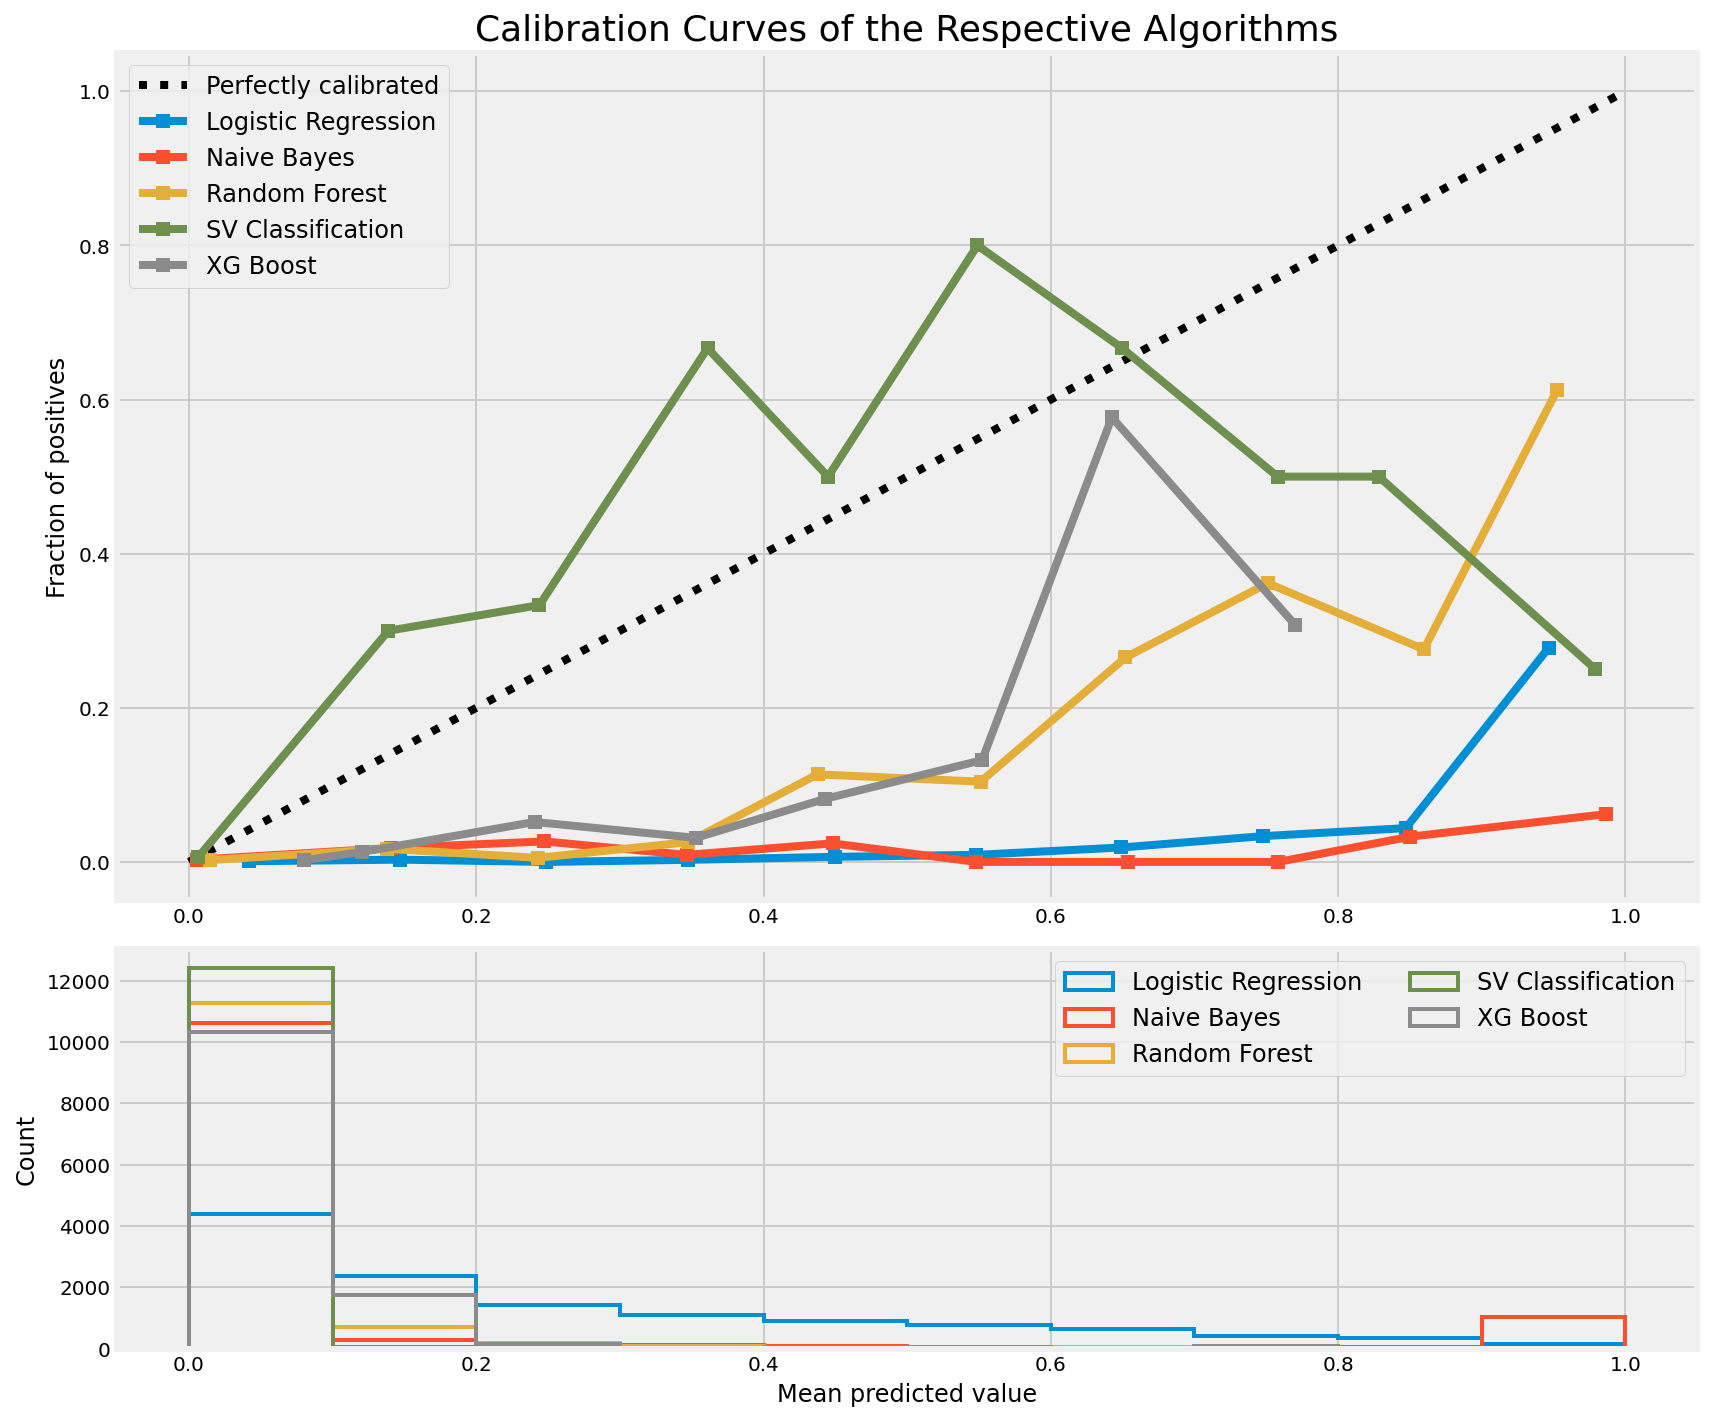

In [152]:
# Generate predicted probabilities, which feed into individual lists and are used to plot the calibration curves
plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for key, clf in clf_dict.items():
    
    clf.fit(X_train_cab, y_train_cab)
    
    # Generating class=1 predicted probabilities
    if hasattr(clf, "predict_proba"):
        train_pos = clf.predict_proba(X_train_cab)[:, 1] # Predicted probability output is a 1D Numpy array
        test_pos = clf.predict_proba(X_test_cab)[:, 1]
    else:  # use decision function instead (eg SVC)
        train_pos = clf.decision_function(X_train_cab) # Predicted probability output is a 1D Numpy array
        train_pos = (train_pos - train_pos.min()) / (train_pos.max() - train_pos.min())        
        test_pos = clf.decision_function(X_test_cab)
        test_pos = (test_pos - test_pos.min()) / (test_pos.max() - test_pos.min())     

        
    # Appending the two 1D Numpy arrays of probabilities from above end-to-end
    if key == 'Logistic Regression':
        logit_prob = np.append(train_pos, test_pos) 
    elif key == 'Naive Bayes':
        gnb_prob = np.append(train_pos, test_pos)
    elif key == 'Random Forest':
        rf_prob = np.append(train_pos, test_pos)
    elif key == 'SV Classification':
        svc_prob = np.append(train_pos, test_pos)
    else:
        xgb_prob = np.append(train_pos, test_pos)

    # Preparing calibration curves
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_cab, test_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (key, ))

    ax2.hist(test_pos, range=(0, 1), bins=10, label=key,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left", fontsize=12)
ax1.set_title('Calibration Curves of the Respective Algorithms', fontsize=18)

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper right", ncol=2, fontsize=12)

plt.tight_layout()
plt.show()

The probability calibration curve sorts the predicted probabilities of class 1 in the target variable. It then bins the probabilities (according to 10 bins in this case) and calculates the **mean of the predicted probabilities** in each bin. It also calculates the percentage of **actual class 1 observations** in each bin

The percentage of class 1 in each bin that is actually in class 1 of the target variable. This is determined by looking at what values these points are actually assigned in y compared to the emperical truth.

Accurate **predicted probabilities** would be expected to line up closely to the **actual percentage of class 1 observations** in each bin. This would be consistent with the theoretical "perfectly calibrated" line. Otherwise the two probabilities will diverge, which is what we see in this case.

**All five algorithms show sizeable divergences from the "perfectly calibrated" line**. This means that the predicted probability output need to be **calibrated** first.

## 5. Results: Comparative Probability Distributions Comparative Probability Distributions <a class="anchor" id="sec_5"></a>

In [153]:
# creating a dataframe with the predicted probabilities after grid-search process
pred_probabilities = pd.DataFrame(
                                {'Logistic Regression': logit_prob,
                                'Naive Bayes': gnb_prob, 
                                'Random Forest': rf_prob,
                                'SV Classification': svc_prob,
                                'XG Boost': xgb_prob
                                })

In [154]:
# Predicted probabilities DataFrame from uncalibrated training set
pred_probabilities

,Logistic Regression,Naive Bayes,Random Forest,SV Classification,XG Boost
0,0.101930,1.119062e-05,0.000000,0.002171,0.078337
1,0.680691,2.972732e-01,0.000000,0.025599,0.090330
2,0.738207,9.611440e-01,0.008854,0.031085,0.090330
3,0.383105,1.891779e-09,0.013389,0.003061,0.084892
4,0.071200,1.040876e-05,0.000000,0.001938,0.075606
...,...,...,...,...,...
41624,0.036298,1.220420e-06,0.004581,0.000384,0.077375
41625,0.021056,3.993102e-06,0.000000,0.002149,0.075606
41626,0.011203,1.204782e-06,0.000000,0.002209,0.075606
41627,0.127822,1.638213e-05,0.000000,0.002417,0.078337


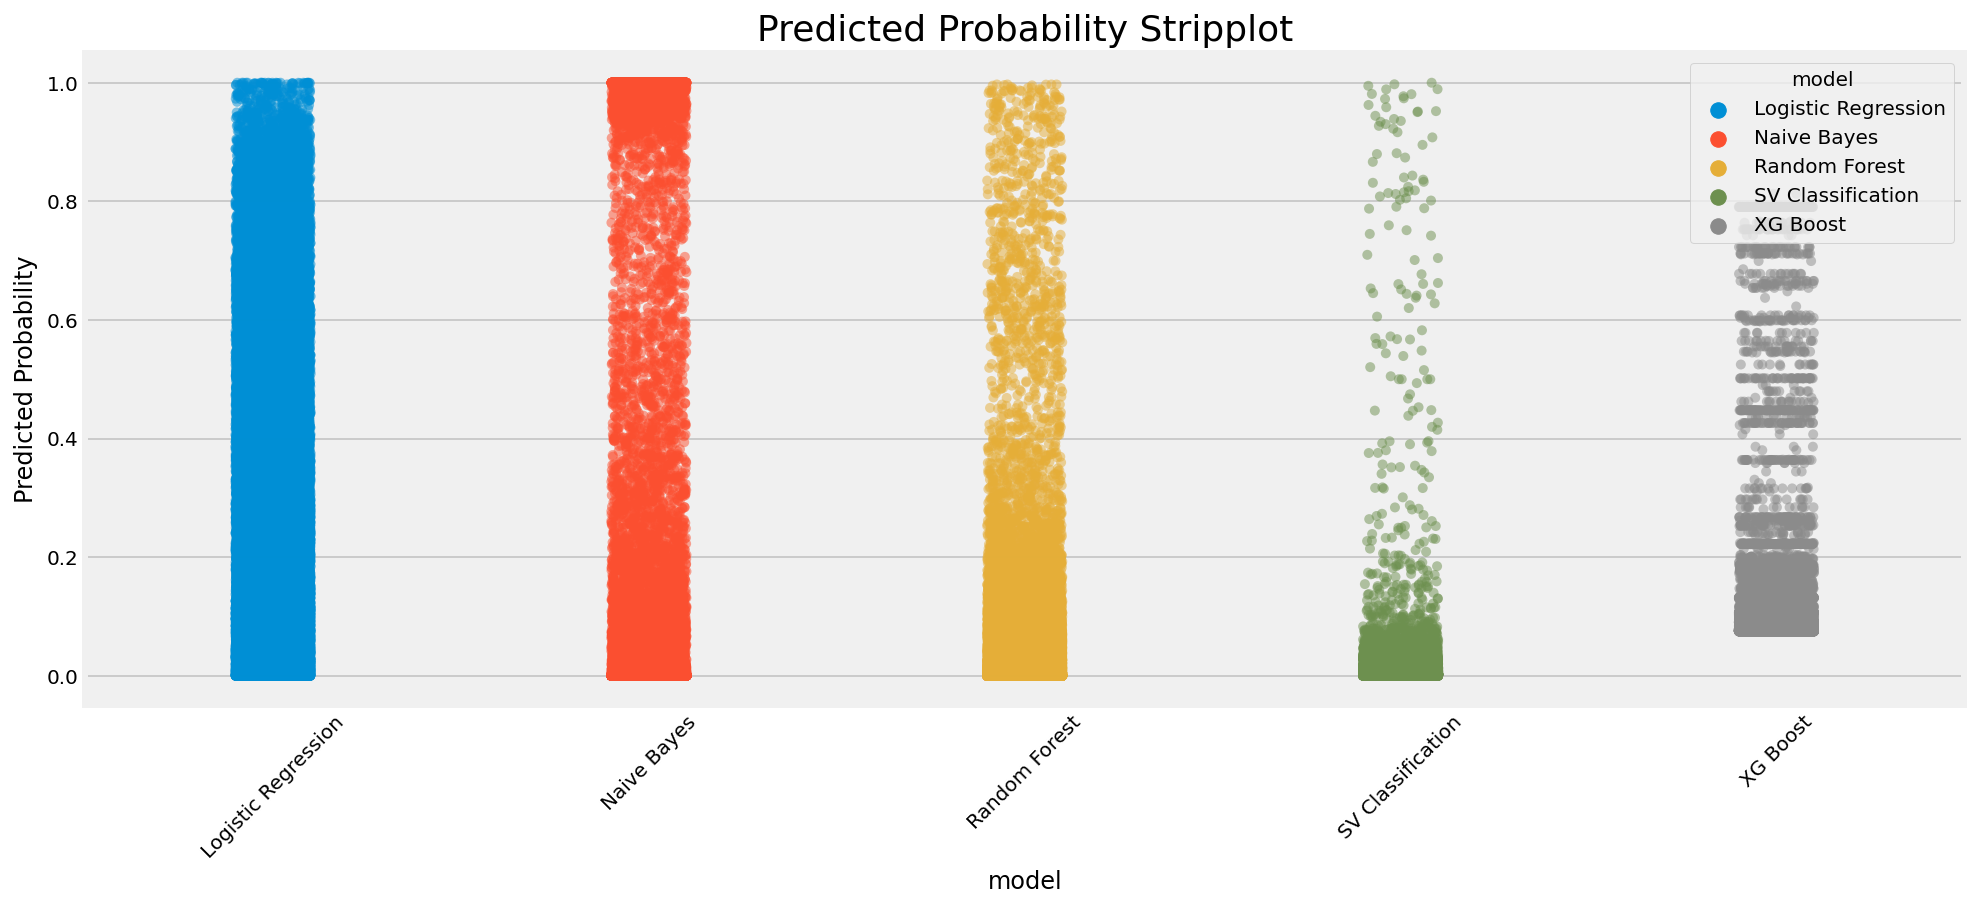

In [155]:
# builduing the plotting for predicted probability stripplot by model
fig, ax = plt.subplots(figsize=(15,6))

df_melt = pd.melt(pred_probabilities, var_name='model', value_name='probabilities')
sns.stripplot(x='model', y='probabilities', data=df_melt, hue='model', jitter=0.1, alpha=0.5, ax=ax)

ax.set_ylabel("Predicted Probability")
#ax.legend(loc="upper right", fontsize=11)
ax.set_ylim([-0.05, 1.05])
plt.title('Predicted Probability Stripplot', fontsize=18)
plt.xticks(rotation=45)
plt.show()

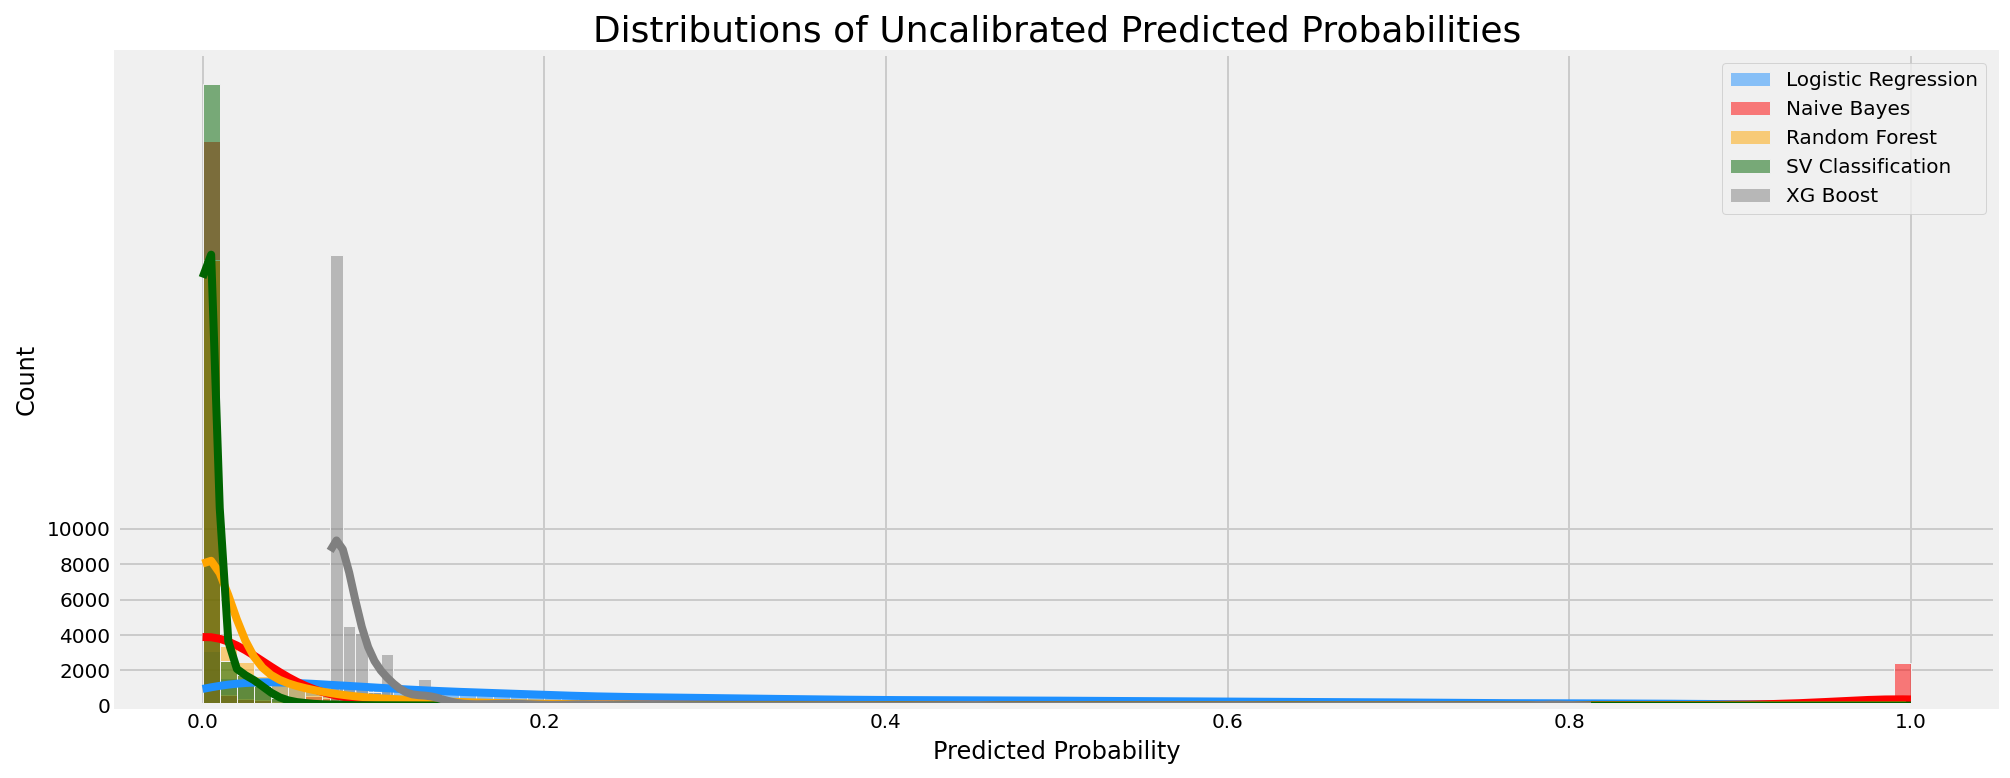

In [156]:
# builduing the plotting for the distribution of predicted probabilities by model
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(pred_probabilities['Logistic Regression'], bins=100, kde=True, ax=ax, color='dodgerblue', 
             label='Logistic Regression')
sns.histplot(pred_probabilities['Naive Bayes'], bins=100, kde=True, ax=ax, color='red', label='Naive Bayes')
sns.histplot(pred_probabilities['Random Forest'], bins=100, kde=True, ax=ax, color='orange',
             label='Random Forest')
sns.histplot(pred_probabilities['SV Classification'], bins=100, kde=True, ax=ax, color='darkgreen', 
             label='SV Classification')
sns.histplot(pred_probabilities['XG Boost'], bins=100, kde=True, ax=ax, color='gray', 
             label='XG Boost')

ax.yaxis.set_ticks(np.arange(0.00, 11000, 2000))
ax.legend(loc="center", fontsize=12)
ax.set_xlabel("Predicted Probability")
plt.title('Distributions of Uncalibrated Predicted Probabilities', fontsize=18)
plt.legend();

## 6. Fitting Optimal Models on Training Data <a class="anchor" id="sec_6"></a>

In [157]:
f1_scorer = make_scorer(f1_score)

In [158]:
# Must use stratified kFold for the cross-validation given the imbalanced data
kf = StratifiedKFold(n_splits=3)

In [159]:
# fitting the logistic regression model
logit.fit(X_train, y_train)
y_hat_train_lr = logit.predict(X_train)
y_hat_test_lr = logit.predict(X_test)
scores_lr = cross_val_score(logit, X_train, y_train, scoring=f1_scorer, cv=kf)

print("Logit CV F1 scores:", scores_lr)
print("Logit mean CV score:", np.mean(scores_lr))

Logit CV F1 scores: [0.03859333 0.05405405 0.56818182]
Logit mean CV score: 0.22027639985259465


In [160]:
# fitting the naive bayes model
gnb.fit(X_train, y_train)
y_hat_train_gnb = gnb.predict(X_train)
y_hat_test_gnb = gnb.predict(X_test)
scores_gnb = cross_val_score(gnb, X_train, y_train, scoring=f1_scorer, cv=kf)

print("NB CV F1 scores:", scores_gnb)
print("NB mean CV score:", np.mean(scores_gnb))

NB CV F1 scores: [0.06559572 0.04676362 0.75647668]
NB mean CV score: 0.28961200525394687


In [161]:
# fitting the random forest model
rf.fit(X_train, y_train)
y_hat_train_rf = rf.predict(X_train)
y_hat_test_rf = rf.predict(X_test)
scores_rf = cross_val_score(rf, X_train, y_train, scoring=f1_scorer, cv=kf)

print("RF CV F1 scores:", scores_rf)
print("RF mean CV score:", np.mean(scores_rf))

RF CV F1 scores: [0.32822757 0.38095238 0.34117647]
RF mean CV score: 0.35011880755219665


In [162]:
# fitting the SVM model
svc.fit(X_train, y_train)
y_hat_train_svc = svc.predict(X_train)
y_hat_test_svc = svc.predict(X_test)
scores_svc = cross_val_score(svc, X_train, y_train, scoring=f1_scorer, cv=kf)

print("SVC CV F1 scores:", scores_svc)
print("SVC mean CV score:", np.mean(scores_svc))

SVC CV F1 scores: [0.03693182 0.05642257 0.56818182]
SVC mean CV score: 0.22051206846374916


In [163]:
# fitting the XGradient Boost model
xgb.fit(X_train, y_train)
y_hat_train_xgb = xgb.predict(X_train)
y_hat_test_xgb = xgb.predict(X_test)
scores_xgb = cross_val_score(xgb, X_train, y_train, scoring=f1_scorer, cv=kf)

print("XGB CV F1 scores:", scores_xgb)
print("XGB mean CV score:", np.mean(scores_xgb))

XGB CV F1 scores: [0.37119114 0.41423948 0.26737968]
XGB mean CV score: 0.3509367656930347


All the **mean CV scores** above confirm the **'best_score_' figures** from the **GridsearchCV** executed previously.

## 7. Results: Comparative Test Scoring <a class="anchor" id="sec_7"></a>

In [164]:
# Dictionary of fitted classifiers taken from above
fitted_dict = {
    'Logistic Regression': logit,
    'Naive Bayes': gnb, 
    'Random Forrest': rf,
    'SV Classification': svc, 
    'XG Boost' : xgb   
}

In [165]:
# defining fuction which return scores after fitting
def batch_clf(X_train, y_train, X_test, y_test, dictionary, verbose=True):
    '''
    Loops through dictionary of fitted models, tests them and returns metrics
    '''
    train_f1_scores = []
    test_f1_scores = []
    train_cohen_scores = []
    test_cohen_scores = []
    train_pre_scores = []
    test_pre_scores = []
    train_acc_scores = []
    test_acc_scores = []
    
    # Loop through dictionary of fitted models:
    for key, clf in dictionary.items():
        
        # Get predictions
        train_preds = clf.predict(X_train)
        test_preds = clf.predict(X_test)
        
        #Get F1 scores
        train_f1 = f1_score(y_train, train_preds, average='binary')
        train_f1_scores.append(round(train_f1, 4))
        test_f1 = f1_score(y_test, test_preds, average='binary')
        test_f1_scores.append(round(test_f1, 4))
        
        # Get Cohen's kappa
        train_cohen = cohen_kappa_score(y_train, train_preds)
        train_cohen_scores.append(round(train_cohen, 4))
        test_cohen = cohen_kappa_score(y_test, test_preds)
        test_cohen_scores.append(round(test_cohen, 4))
        
        # Get AUC of precision-recall curves
        train_pre = average_precision_score(y_train, train_preds, average='macro')
        train_pre_scores.append(round(train_pre, 4))
        test_pre = average_precision_score(y_test, test_preds, average='macro')
        test_pre_scores.append(round(test_pre, 4))           
                
        #Get accuracy scores
        train_acc = accuracy_score(y_train, train_preds)
        train_acc_scores.append(round(train_acc,4))
        test_acc = accuracy_score(y_test, test_preds)
        test_acc_scores.append(round(test_acc,4))
        
    # Create results dataframe
    results = pd.DataFrame({'Model': list(dictionary.keys()), 
                            'Train F1': train_f1_scores,
                            'Test F1': test_f1_scores,
                            "Train Cohen's kappa" : train_cohen_scores,
                            "Test Cohen's kappa" : test_cohen_scores,
                            'Train PR-AUC': train_pre_scores,
                            'Test PR-AUC': test_pre_scores,
                            'Train Accuracy': train_acc_scores,
                            'Test Accuracy': test_acc_scores,
                            })

    return results

In [166]:
# printing the results
results = batch_clf(X_train, y_train, X_test, y_test, fitted_dict)
results

,Model,Train F1,Test F1,Train Cohen's kappa,Test Cohen's kappa,Train PR-AUC,Test PR-AUC,Train Accuracy,Test Accuracy
0,Logistic Regression,0.0729,0.1548,0.0573,0.1144,0.0329,0.0811,0.8192,0.7433
1,Naive Bayes,0.0872,0.1308,0.0722,0.0926,0.0342,0.0471,0.8778,0.8599
2,Random Forrest,0.6612,0.5525,0.6572,0.5392,0.4938,0.3218,0.9911,0.9735
3,SV Classification,0.0887,0.1664,0.0735,0.1275,0.0402,0.0792,0.8528,0.8010
4,XG Boost,0.4137,0.4056,0.4075,0.3907,0.1826,0.1796,0.9873,0.9711


### 7.1. Confusion Matrices <a class="anchor" id="sec_7_1"></a>

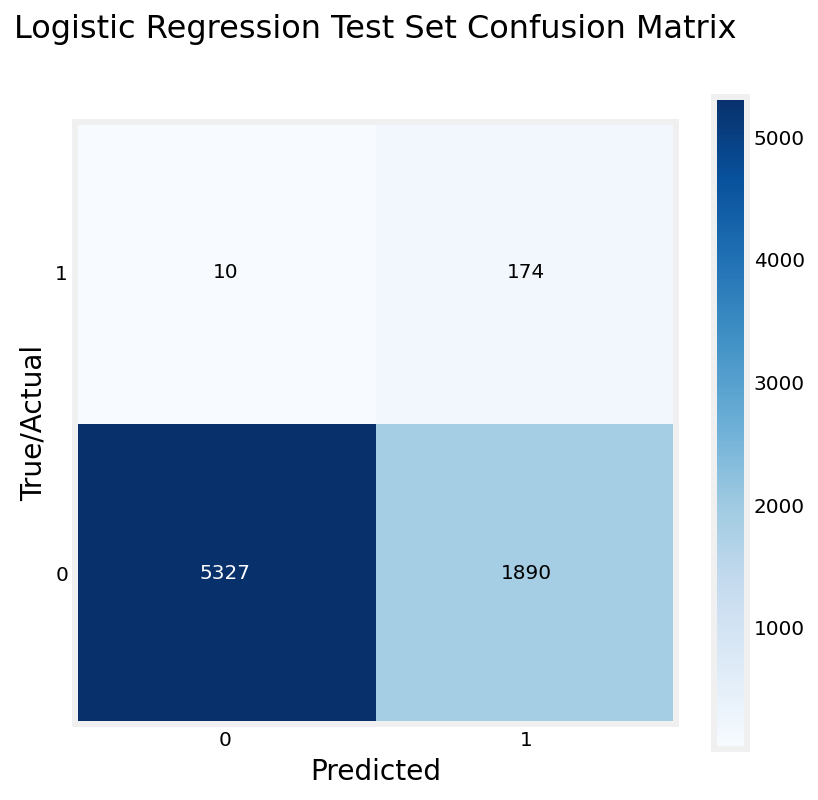

In [167]:
# Logit confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_lr, figsize=(6,6))
plt.title('Logistic Regression Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [168]:
print(metrics.classification_report(y_test, y_hat_test_lr))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85      7217
           1       0.08      0.95      0.15       184

    accuracy                           0.74      7401
   macro avg       0.54      0.84      0.50      7401
weighted avg       0.98      0.74      0.83      7401



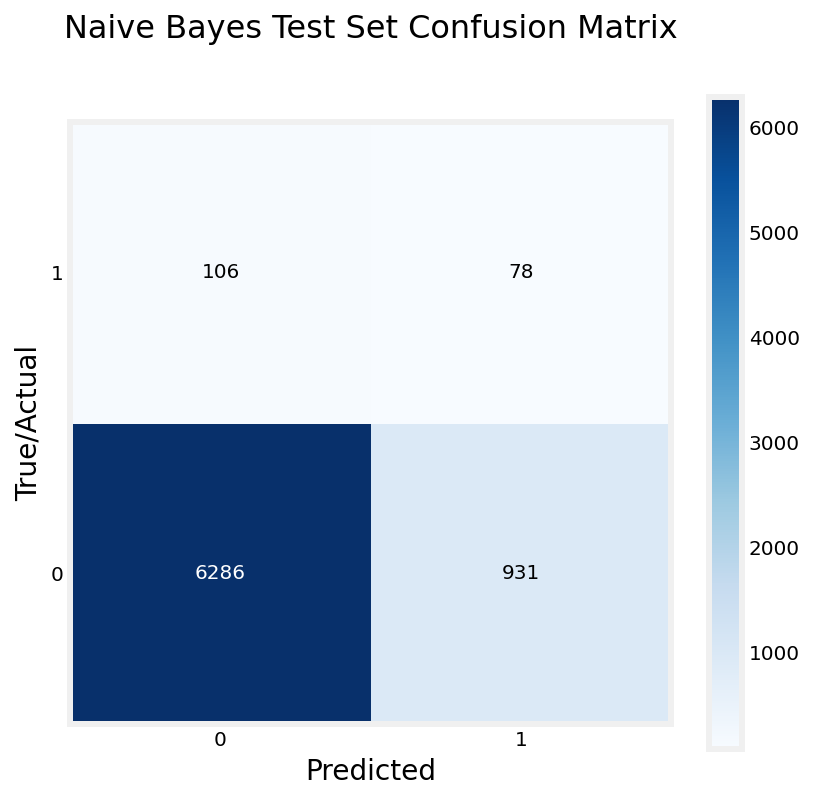

In [169]:
# NB confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_gnb, figsize=(6,6))
plt.title('Naive Bayes Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [170]:
print(metrics.classification_report(y_test, y_hat_test_gnb))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7217
           1       0.08      0.42      0.13       184

    accuracy                           0.86      7401
   macro avg       0.53      0.65      0.53      7401
weighted avg       0.96      0.86      0.90      7401



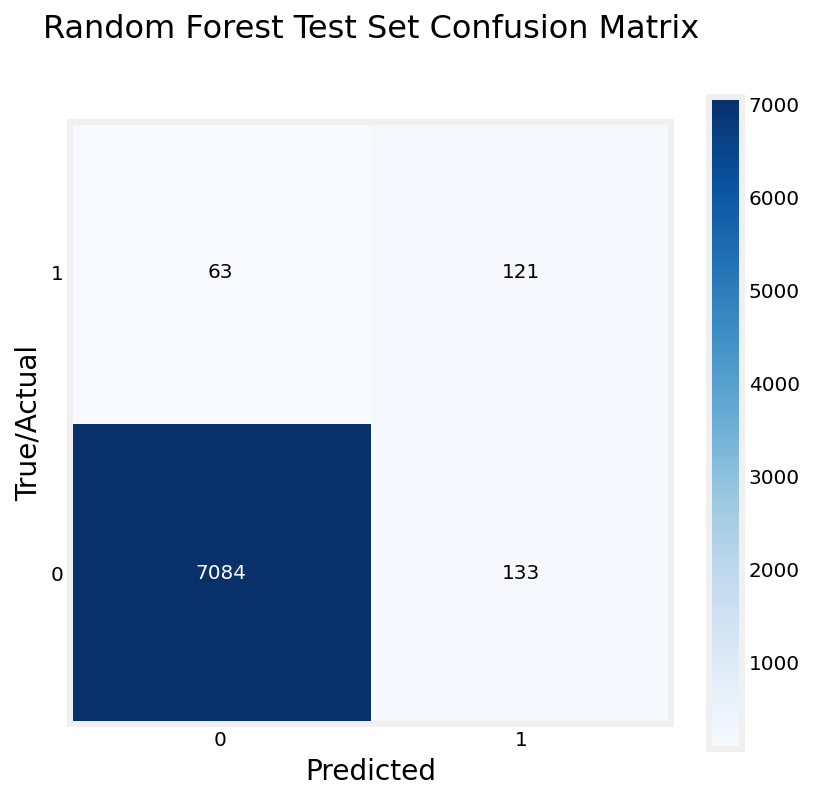

In [171]:
# RF confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_rf, figsize=(6,6))
plt.title('Random Forest Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [172]:
print(metrics.classification_report(y_test, y_hat_test_rf))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7217
           1       0.48      0.66      0.55       184

    accuracy                           0.97      7401
   macro avg       0.73      0.82      0.77      7401
weighted avg       0.98      0.97      0.98      7401



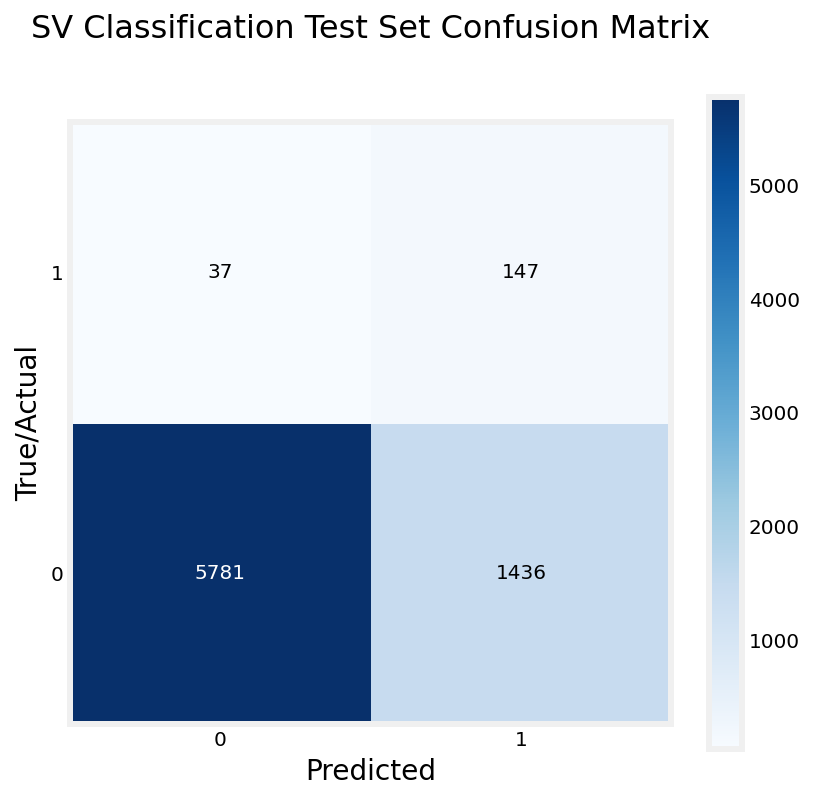

In [173]:
# SVC confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_svc, figsize=(6,6))
plt.title('SV Classification Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [174]:
print(metrics.classification_report(y_test, y_hat_test_svc))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89      7217
           1       0.09      0.80      0.17       184

    accuracy                           0.80      7401
   macro avg       0.54      0.80      0.53      7401
weighted avg       0.97      0.80      0.87      7401



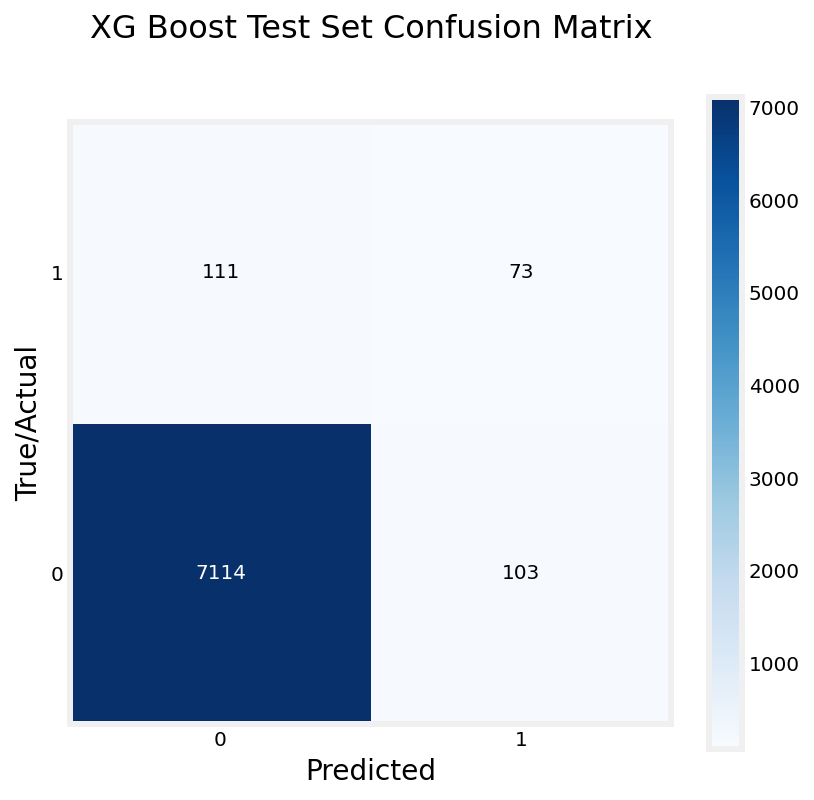

In [175]:
# XGB confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, y_hat_test_xgb, figsize=(6,6))
plt.title('XG Boost Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [176]:
print(metrics.classification_report(y_test, y_hat_test_xgb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7217
           1       0.41      0.40      0.41       184

    accuracy                           0.97      7401
   macro avg       0.70      0.69      0.70      7401
weighted avg       0.97      0.97      0.97      7401



### 7.2. Conclusion about classifiers <a class="anchor" id="sec_7_2"></a>

The details of the individual confusion matrices are revealing. **Logit has the best recall rate for defaulters (1) by far at 0.95%**, but also the **reasonable recall rate for non-defaulters of 0.74**, reaching a **total accuracy of 0.74**.

**SVM is the second best model with recall rates of 0.80 for both groups of defaulters and non-defaulters.** 

The weakest results are from **Naive Bayes and XGB in terms of recall scores**. 

Therefore, **Logit, is the better model since there is a preference for the recall rate** (followed by SVM) relative to precision in this kind of default prediction task.


### 7.3. ROC Analysis considering other models <a class="anchor" id="sec_7_3"></a>
#### Considering that the logistic regression was the better model from the previous analysis, from here we use this model to compare with other models that were not trained by this code but by other processes.

In [177]:
# getting the coefficients and intercepts of logistic regression from previous analysis
print('w = ',logit.coef_)
print('b = ',logit.intercept_)

w =  [[-2.3829061  -0.27281473 -4.09159801 -1.65234255  1.08826274 -0.73668032
   1.47549177 -0.62968977  0.5801115   0.94585995 -0.10530038 -0.33545831
   0.79567947 -0.78424159 -0.73748939 -0.82132979]]
b =  [1.55654566]


#### Builduing a table with all coefficients and their respective statistics.

In [187]:
y_test = np.ravel(y_test)
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [188]:
probs = logit.predict_proba(X_test)
preds = probs[:,1]

In [192]:
from scipy import stats

#newX = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train))
#MSE = (sum((y_test-preds)**2))/(len(newX)-len(newX.columns))
params = np.append(logit.intercept_,logit.coef_)

# Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X_train),1)), X_train, axis=1)
MSE = (sum((y_test-preds)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p-values"] = [params,sd_b,ts_b,p_values]
print(myDF3)

    Coefficients  Standard Errors  t values  p-values
0         1.5565              NaN       NaN       NaN
1        -2.3829            0.003  -799.213       0.0
2        -0.2728            0.004   -71.672       0.0
3        -4.0916            0.014  -294.793       0.0
4        -1.6523            0.000 -7579.390       0.0
5         1.0883              NaN       NaN       NaN
6        -0.7367              NaN       NaN       NaN
7         1.4755              NaN       NaN       NaN
8        -0.6297              NaN       NaN       NaN
9         0.5801              NaN       NaN       NaN
10        0.9459              NaN       NaN       NaN
11       -0.1053              NaN       NaN       NaN
12       -0.3355              NaN       NaN       NaN
13        0.7957              NaN       NaN       NaN
14       -0.7842              NaN       NaN       NaN
15       -0.7375              NaN       NaN       NaN
16       -0.8213            0.002  -462.644       0.0


<ipython-input-192-6a274fa18fcc>:12: RuntimeWarning: invalid value encountered in sqrt
  sd_b = np.sqrt(var_b)


#### Loading other models to be compared with our new logistic regressions

In [193]:
# reading the new dataset with other models from other codes
df_models0_1 = pd.read_excel(r'models0and1.xlsx')

In [194]:
# checking the format of this new dataframe
df_models0_1

,y_test,preds_model0,preds_model1,y_pred_model0,y_pred_model1
0,0,0.389120,0.096173,0,0
1,0,0.394678,0.108150,0,0
2,0,0.398150,0.114110,0,0
3,0,0.433083,0.364638,0,0
4,0,0.414519,0.137032,0,0
...,...,...,...,...,...
7396,0,0.428407,0.116191,0,0
7397,0,0.431268,0.127010,0,0
7398,0,0.417434,0.154050,0,0
7399,0,0.411736,0.137088,0,0


In [195]:
# formatting the data of our logit model (model 2) to array format
df_ytest = pd.DataFrame(df_models0_1, columns=['y_test'])
df_ytest = np.ravel(df_ytest)
df_ytest

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [196]:
# formatting the data of model 0 to array format
df_preds_m0 = pd.DataFrame(df_models0_1, columns=['preds_model0'])
df_preds_m0= np.ravel(df_preds_m0)
df_preds_m0

array([0.38911972, 0.39467753, 0.39814953, ..., 0.4174343 , 0.41173589,
       0.40819055])

In [197]:
# formatting the data of model 1 to array format
df_preds_m1 = pd.DataFrame(df_models0_1, columns=['preds_model1'])
df_preds_m1= np.ravel(df_preds_m1)
df_preds_m1

array([0.09617288, 0.10815047, 0.11411032, ..., 0.1540498 , 0.13708827,
       0.12969796])

In [198]:
# formatting the predicted data of model 0 to array format
df_ypred_m0 = pd.DataFrame(df_models0_1, columns=['y_pred_model0'])
df_ypred_m0= np.ravel(df_ypred_m0)
df_ypred_m0

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [199]:
# formatting the predicted data of model 1 to array format
df_ypred_m1 = pd.DataFrame(df_models0_1, columns=['y_pred_model1'])
df_ypred_m1= np.ravel(df_ypred_m1)
df_ypred_m1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### Creating the necessary elements and rates from models 0 and 1 to plot the ROC curve 

In [206]:
# for our logit model (model 2)
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

In [207]:
# for model 0
fpr_m0, tpr_m0, threshold_m0 = roc_curve(df_ytest, df_preds_m0)
roc_auc_m0 = auc(fpr_m0, tpr_m0)

In [208]:
# for model 1
fpr_m1, tpr_m1, threshold_m1 = roc_curve(df_ytest, df_preds_m1)
roc_auc_m1 = auc(fpr_m1, tpr_m1)

In [209]:
print(roc_auc_m0, roc_auc_m1, roc_auc)

0.8672066557825424 0.892740419661307 0.9009539673837739


#### Plotting the ROC curve for models 0, 1 and 2

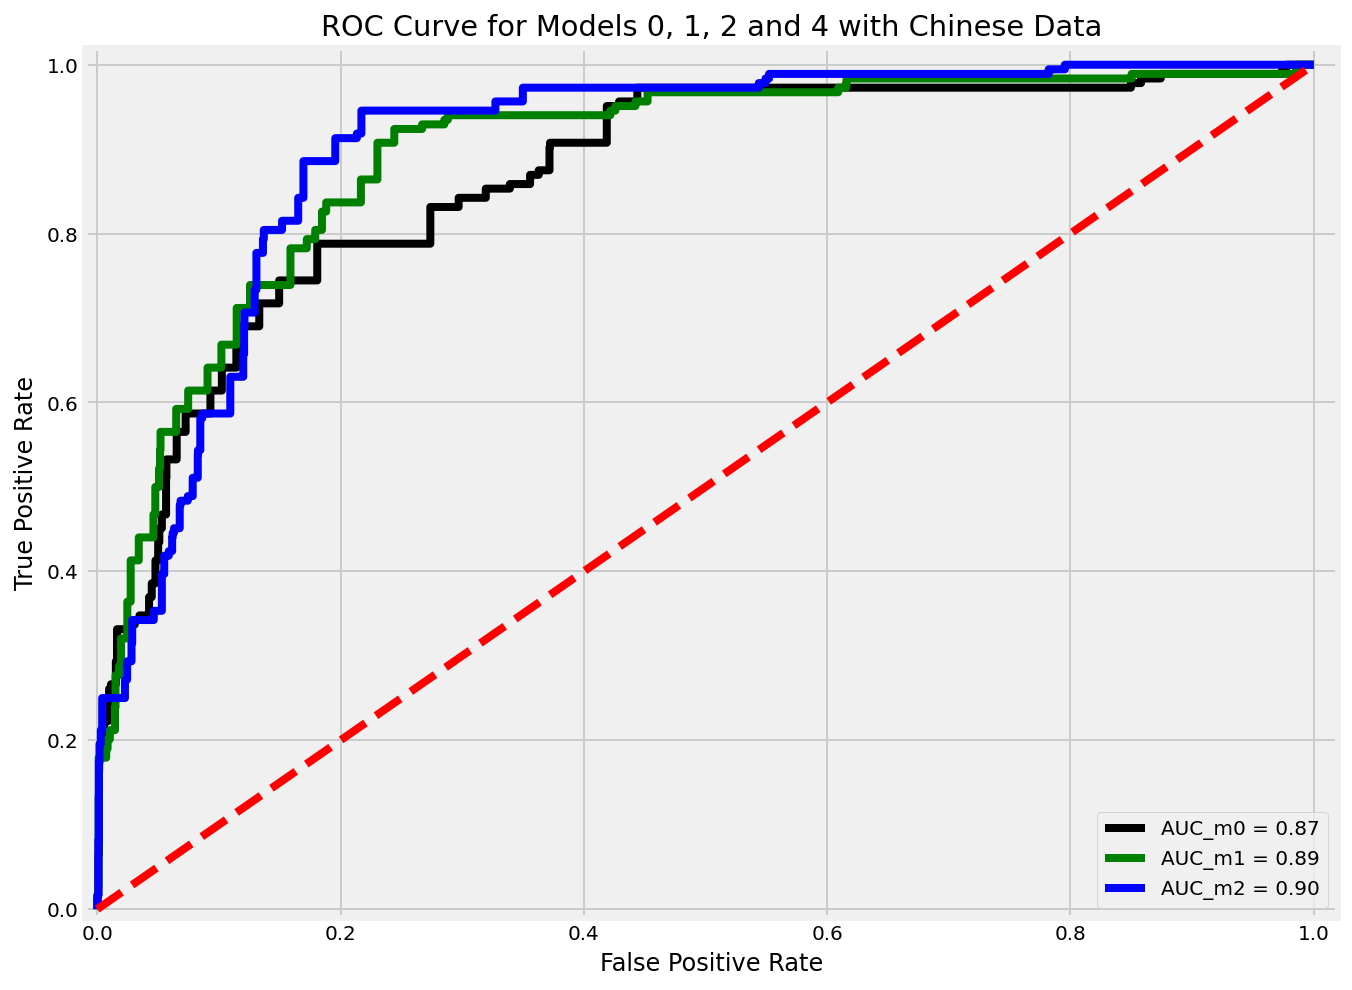

In [210]:
# method I: plt
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.title('ROC Curve for Models 0, 1, 2 and 4 with Chinese Data')
plt.plot(fpr_m0, tpr_m0, 'black', label = 'AUC_m0 = %0.2f' % roc_auc_m0)
plt.plot(fpr_m1, tpr_m1, 'g', label = 'AUC_m1 = %0.2f' % roc_auc_m1)
plt.plot(fpr, tpr, 'b', label = 'AUC_m2 = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.02])
plt.ylim([-0.01, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 8. Conclusion <a class="anchor" id="sec_8"></a>

By the ROC curve we can observe that **logit model trained by this code (model 2)** has a **better performance** than models 0 and 1 (which are models from previous works) presenting a higher AUC. It is also capable of discrimating the defaulters better than the other 2 models.